In [1]:
# you don't really care about this code
# these are just basic module imports

import sys
import os
from pathlib import Path
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

sys.path.append(os.path.abspath("../src"))
# We change the working directory to the root of the project
# Run this only once
root_path = Path.cwd().parent
os.chdir(root_path)
sys.path.append(root_path / "src")

In [2]:
from notebook_utils.parquet_utils import load_dataframe
from src.patch_processing.svg import SVG

/home/mathis/anaconda3/envs/projetOCR/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
representatives_df = load_dataframe('outputs/clustering_results_full/label_representatives')

Loading column: bin_patch
Loading column: img_patch
Loading column: page
Loading column: file
Loading column: left
Loading column: top
Loading column: width
Loading column: height
Loading column: label
Loading column: reading_order
Loading column: svg
Loading column: unc_qwen
Loading column: char_qwen
Loading column: histogram
Loading column: membership
Loading column: degree_centrality
Loading column: best_hog_config
Loading column: best_cell_size
Loading column: best_grdt_sigma
Loading column: best_num_bins
✓ Loaded from outputs/clustering_results_full/label_representatives


In [4]:
filtered_df = load_dataframe('outputs/clustering_results_full/filtered_patches')

Loading column: bin_patch
Loading column: img_patch
Loading column: page
Loading column: file
Loading column: left
Loading column: top
Loading column: width
Loading column: height
Loading column: label
Loading column: reading_order
Loading column: svg
Loading column: unc_qwen
Loading column: char_qwen
Loading column: histogram
Loading column: membership
Loading column: degree_centrality
Loading column: best_hog_config
Loading column: best_cell_size
Loading column: best_grdt_sigma
Loading column: best_num_bins
✓ Loaded from outputs/clustering_results_full/filtered_patches


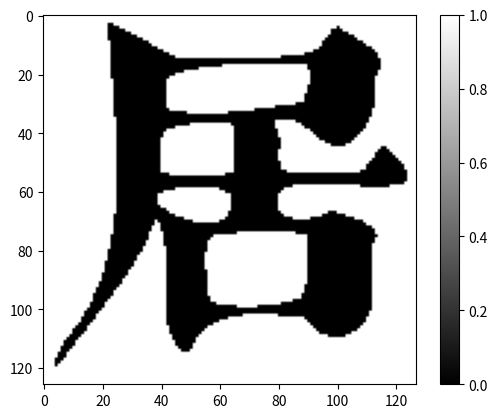

In [ ]:
import matplotlib.pyplot as plt
plt.imshow((filtered_df.iloc[0]['svg'].render() > 0).astype(float), cmap="grey")
plt.colorbar()

# Note that the characters correspond to areas equal 0!

In [ ]:
from src.patch_processing.renderer import Renderer

renderer = Renderer(
    scale=1,
    dpi=128,
    bin_thresh=1.0,
    svg_imgs=filtered_df['svg']
)

# show a sample image so that you realize what it is
plt.imshow(renderer[0])

Rendering:  69%|██████▊   | 8658/12624 [00:30<00:14, 279.67img/s]

Filtered images:   0%|          | 0/12624 [00:00<?, ?it/s]

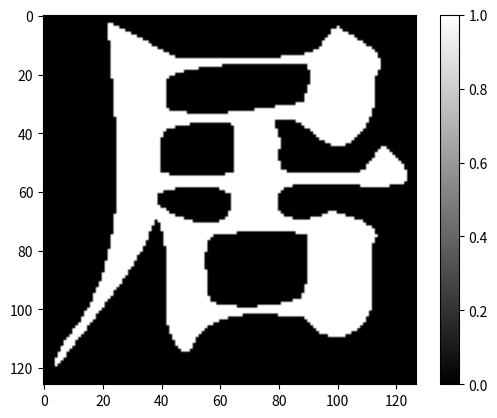

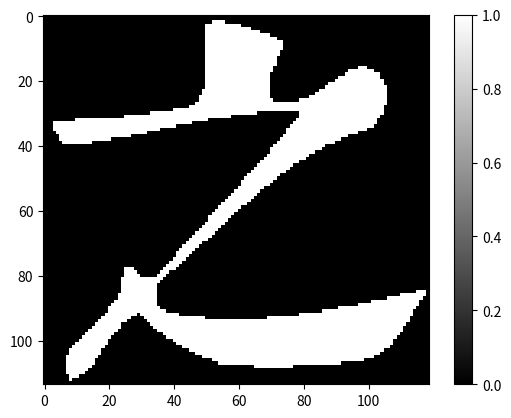

Filtered images:   0%|          | 1/12624 [00:26<92:17:24, 26.32s/it]


KeyboardInterrupt: 

In [34]:
import numpy as np
from skimage.metrics import hausdorff_distance
from tqdm import tqdm

N_filtered = len(filtered_df)
N_reps = len(representatives_df)

# Initialize matrix
distance_matrix = np.zeros((N_filtered, N_reps))

# Compute distances - note the corrected loop order
for i in tqdm(range(N_filtered), desc="Filtered images"):
    filtered_img = renderer._render_single(filtered_df['svg'].iloc[i]) == 1
    
    for j in tqdm(range(N_reps), desc="Representatives", leave=False):
        repr_img = renderer._render_single(representatives_df['svg'].iloc[j]) == 1
        
        # ========== WARNING ===========
        # Please, do not forget that
        # you should align the two
        # images first! Before computing
        # the Haursdoff distance
        # =============================

        # Make sure that the images are set to 1
        # inside the characters and 0 outside
        if i == 0 and j == 0:
            plt.imshow(filtered_img, cmap="gray")
            plt.colorbar()
            plt.show()
            plt.imshow(repr_img, cmap="gray")
            plt.colorbar()
            plt.show()


        distance_matrix[i, j] = hausdorff_distance(filtered_img, repr_img)